In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from os import listdir
from sklearn.model_selection import train_test_split
print ('The version of TensorFlow is {}'.format(tf.__version__))

c:\anaconda\pkgs\python-3.6.3-h9e2ca53_1\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


The version of TensorFlow is 1.4.0


## Load the 12-year incident/accident data

In [2]:
root_path = './data'

appended_data = []
for file_name in listdir(root_path):
    file_path = root_path + '/' + file_name.encode().decode('utf-8')
    data_from_one_csv = pd.read_csv(file_path, skiprows=1)
    appended_data.append(data_from_one_csv)
    
data = pd.concat(appended_data, axis=0)
data = data.drop(columns = ['ACN', 'Date', 'Local Time Of Day', 'Ceiling', 'Callback', 'Callback.1', 'Unnamed: 96'])
data = data.rename(index=str, columns={"Flight Phase": "Flight Phase1"})

## drop the rows with empty synopsis description
data = data[pd.notnull(data['Synopsis'])]

X = data.drop(columns = 'Result')
Y_raw = pd.DataFrame(data['Result'])

processed_Y = []
count_multiple_outcome = 0
for index, row in Y_raw.iterrows():
    #print (index, row['Result'])
    outcome = row['Result']
    if type(outcome) == np.float:
        res = 'unknown'
        processed_Y.append([res])
    elif ';' in outcome:
        count_multiple_outcome += 1
        res = str(outcome).split(';')
        processed_Y.append(res)
    else:
        res = outcome
        processed_Y.append([res])

In [3]:
count_multiple_outcome/X.shape[0]

0.502222291050439

## Perform risk-based event outcome cetegorization

In [4]:
## compress the number of labels to be predicted --> map result to risk level
rate_nine = ['General Declared Emergency', 'General Physical Injury / Incapacitation', 'Flight Crew Inflight Shutdown', 
             'Air Traffic Control Separated Traffic', 'Aircraft Aircraft Damaged']

rate_seven = ['General Evacuated', 'Flight Crew Landed as Precaution', 'Flight Crew Regained Aircraft Control', 
              'Air Traffic Control Issued Advisory / Alert', 'Flight Crew Landed in Emergency Condition',
              'Flight Crew Landed In Emergency Condition']

rate_five = ['General Work Refused', 'Flight Crew Became Reoriented', 'Flight Crew Diverted', 
             'Flight Crew Executed Go Around / Missed Approach', 
             'Flight Crew Overcame Equipment Problem', 'Flight Crew Rejected Takeoff', 'Flight Crew Took Evasive Action', 
             'Air Traffic Control Issued New Clearance']

rate_three = ['General Maintenance Action', 'General Flight Cancelled / Delayed', 
              'General Release Refused / Aircraft Not Accepted', 
              'Flight Crew Overrode Automation', 'Flight Crew FLC Overrode Automation',
              'Flight Crew Exited Penetrated Airspace', 
              'Flight Crew Requested ATC Assistance / Clarification', 'Flight Crew Landed As Precaution',
              'Flight Crew Returned To Clearance', 'Flight Crew Returned To Departure Airport',
              'Aircraft Automation Overrode Flight Crew']

rate_one = ['General Police / Security Involved', 'Flight Crew Returned To Gate', 'Aircraft Equipment Problem Dissipated', 
            'unknown', 'Air Traffic Control Provided Assistance',
            'General None Reported / Taken', 'Flight Crew FLC complied w / Automation / Advisory']

def risk_quantification(val):
    min_risk = []
    for i in range(len(val)):
        item = val[i].lstrip() ## remove the space at the start of each item
        if item in rate_nine:
            min_risk.append(5)
        elif item in rate_seven:
            min_risk.append(4)
        elif item in rate_five:
            min_risk.append(3)
        elif item in rate_three:
            min_risk.append(2)
        elif item in rate_one:
            min_risk.append(1)
    return max(min_risk)


Y_ = []
for i in range(len(processed_Y)):
    if len(processed_Y[i]) > 1:
        val = risk_quantification(processed_Y[i])
        Y_.append(val)
    else:
        item_val = " ".join(processed_Y[i]) ## convert a list to a string
        if item_val in rate_nine:
            Y_.append(5)
        elif item_val in rate_seven:
            Y_.append(4)
        elif item_val in rate_five:
            Y_.append(3)
        elif item_val in rate_three:
            Y_.append(2)
        elif item_val in rate_one:
            Y_.append(1)
        else:
            print (Y['Result'][i])

outcomes = np.asarray(Y_)
Y_true = pd.DataFrame(Y_, index = X.index, columns = ['Result'])
unique, counts = np.unique(outcomes, return_counts=True)
print (unique, counts)

[1 2 3 4 5] [16508  8636 18841  8261 12327]


## Up-sampling the minority classes

In [5]:
from sklearn.utils import resample

data_rev = X.copy(deep=True)
data_rev['Result'] = Y_true

df_majority_1 = data_rev[data_rev['Result']==1]
df_majority_3 = data_rev[data_rev['Result']==3]
df_minority_2 = data_rev[data_rev['Result']==2]
df_minority_4 = data_rev[data_rev['Result']==4]
df_minority_5 = data_rev[data_rev['Result']==5]

# Upsample minority class
df_minority_2_upsampled = resample(df_minority_2, 
                                 replace=True,     # sample with replacement
                                 n_samples=18841,    # to match majority class
                                 random_state=145) # reproducible results
df_minority_4_upsampled = resample(df_minority_4, 
                                 replace=True,     # sample with replacement
                                 n_samples=18841,    # to match majority class
                                 random_state=145) # reproducible results
df_minority_5_upsampled = resample(df_minority_5, 
                                 replace=True,     # sample with replacement
                                 n_samples=18841,    # to match majority class
                                 random_state=145) # reproducible results

df_upsampled = pd.concat([df_majority_1, df_majority_3, df_minority_2_upsampled, df_minority_4_upsampled, 
                          df_minority_5_upsampled])

df_upsampled['Result'].value_counts()

X = df_upsampled.drop(columns = 'Result')
Y_true = df_upsampled['Result']

unique, counts = np.unique(Y_true, return_counts=True)
print ('After the upsampling, the number of each item is: \n')
print (unique)
print (counts)

After the upsampling, the number of each item is: 

[1 2 3 4 5]
[16508 18841 18841 18841 18841]


In [6]:
## copy the data
X_org = X.copy(deep=True)
Y_org = Y_true.copy(deep=True)
X_org.shape

(91872, 89)

## Split the data, the data has three parts: 
##### X_train, Y_train: train the data
##### X_validation, Y_validation: trial data to obtain the performance metrics
##### X_test, Y_test: test data used to compare the performance of hybrid model with SVM and DNN

In [7]:
from sklearn.model_selection import train_test_split

test_random_state = 111
X, X_test, Y, Y_test = train_test_split(X_org, Y_org, test_size = 0.1, random_state = test_random_state)

## Split the data

In [8]:
from sklearn.model_selection import train_test_split

test_size_ratio = 0.06
random_split_seed = 200
X_train, X_validation, Y_train, Y_validation = train_test_split(X['Synopsis'], Y, test_size = test_size_ratio, 
                                                    random_state = random_split_seed)

## Pipeline: Naive Bayes

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', MultinomialNB(alpha = 1, fit_prior=True)),
                    ])

text_clf.fit(X_train, Y_train)
pred_label_NB = text_clf.predict(X_validation)

from sklearn.metrics import classification_report
target_names = [str(i) for i in range(1, 5+1)]
print(classification_report(Y_validation, pred_label_NB, target_names=target_names))

             precision    recall  f1-score   support

          1       0.63      0.49      0.55       947
          2       0.67      0.65      0.66      1017
          3       0.49      0.38      0.43       988
          4       0.56      0.61      0.58      1034
          5       0.57      0.78      0.66       976

avg / total       0.58      0.58      0.58      4962



## Model 1: Support Vector Machine with Linear Kernel

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

text_clf = Pipeline([('vect', CountVectorizer(stop_words = 'english')),
                      ('tfidf', TfidfTransformer()),
                      ('clf', SGDClassifier(loss='epsilon_insensitive', penalty='l2',
                                            alpha=1e-5, random_state=40,
                                            max_iter=10, tol=None)),
                    ])


parameters = {'clf__loss': ['epsilon_insensitive', 'hinge', 'log', 'huber', 'modified_huber', 'perceptron', 
                            'squared_loss', 'squared_epsilon_insensitive', 'squared_hinge'],
              'vect__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'clf__alpha': (1e-2, 1e-3, 1e-4, 1e-5),
              'clf__penalty': ['l1', 'l2', 'elasticnet'],
              'clf__max_iter': (10, 20, 30, 40, 50, 60, 70, 80, 90, 100)
 }

optimal_parameters = {'clf__loss': ['modified_huber'],
              'vect__ngram_range':  [(1, 2)],
              'tfidf__use_idf': [True],
              'clf__alpha': [1e-5],
              'clf__penalty': ['elasticnet'],
              'clf__max_iter': [80],
 }

gs_clf = GridSearchCV(text_clf, optimal_parameters, n_jobs=-1)

gs_clf.fit(X_train, Y_train)
pred_label_SVM = gs_clf.predict(X_validation)

from sklearn.metrics import classification_report
target_names = [str(i) for i in range(1, 6)]
print(classification_report(Y_validation, pred_label_SVM, target_names=target_names))

             precision    recall  f1-score   support

          1       0.73      0.58      0.65       947
          2       0.85      0.94      0.89      1017
          3       0.66      0.60      0.63       988
          4       0.81      0.91      0.86      1034
          5       0.87      0.90      0.88       976

avg / total       0.78      0.79      0.78      4962



In [11]:
print ('Accuracy: ', np.sum(np.equal(Y_validation, pred_label_SVM).astype(int))/20367)
print ('The best set of parameters is \n', gs_clf.best_params_)

Accuracy:  0.19241910934354592
The best set of parameters is 
 {'clf__alpha': 1e-05, 'clf__loss': 'modified_huber', 'clf__max_iter': 80, 'clf__penalty': 'elasticnet', 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}


## Model 2: Processing categorical data

In [12]:
## change column names
new_col_name = []
for col in X_org.columns:
    #print(type(col))
    new_col_name.append(col.replace('/ ', '').replace(' ', '_'))
    
X_org.columns = new_col_name


data_type = []
for item_name in X_org.keys():
    data_type.append(type(X_org[item_name][0]))

print ('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print ('The unique data types across all the items are:', set(data_type))
print ('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

for item_name in X_org.keys():
    ## find the number of NaN in this item
    no = np.sum(X_org[item_name].isna().astype(int))
    #print ('The number of {} with value equal to NaN is {}'.format(item_name, no))
    
    ## Replace the missing value with corresponding values
    if no > 0:
        if type(X_org[item_name][0]) == np.float64:
            X_org[item_name].fillna(-1, inplace = True)
        else:
            X_org[item_name].fillna('unknown', inplace = True)
X_org['Crew_Size'].head()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
The unique data types across all the items are: {<class 'numpy.float64'>, <class 'float'>, <class 'str'>}
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


8     2.0
13    2.0
14    2.0
17    2.0
19    2.0
Name: Crew_Size, dtype: float64

## Data Split

In [13]:
X, X_test, Y, Y_test = train_test_split(X_org, Y_org, test_size = 0.1, random_state = test_random_state)

In [14]:
## Location
Locale_Reference = tf.feature_column.categorical_column_with_hash_bucket('Locale_Reference', 
                                                                         hash_bucket_size = len(set(X['Locale_Reference'])))
State_Reference = tf.feature_column.categorical_column_with_hash_bucket('State_Reference', 
                                                                        hash_bucket_size = len(set(X['State_Reference'])))


## Environment
Flight_Conditions = tf.feature_column.categorical_column_with_hash_bucket('Flight_Conditions', 
                                                                hash_bucket_size = len(set(X['State_Reference'])))
Weather_Elements_Visibility = tf.feature_column.categorical_column_with_hash_bucket('Weather_Elements_Visibility', 
                                                            hash_bucket_size = len(set(X['Weather_Elements_Visibility'])))
Work_Environment_Factor = tf.feature_column.categorical_column_with_hash_bucket('Work_Environment_Factor', 
                                                            hash_bucket_size = len(set(X['Work_Environment_Factor'])))
Light = tf.feature_column.categorical_column_with_hash_bucket('Light', hash_bucket_size = 
                                                              len(set(X['Work_Environment_Factor'])))


## Aircraft
ATC_Advisory = tf.feature_column.categorical_column_with_hash_bucket('ATC_Advisory', 
                                                            hash_bucket_size = len(set(X['ATC_Advisory'])))
Aircraft_Operator = tf.feature_column.categorical_column_with_hash_bucket('Aircraft_Operator', 
                                                                hash_bucket_size = len(set(X['Aircraft_Operator'])))
Make_Model_Name = tf.feature_column.categorical_column_with_hash_bucket('Make_Model_Name', 
                                                            hash_bucket_size = len(set(X['Make_Model_Name'])))
Crew_Size = tf.feature_column.numeric_column('Crew_Size', [1])
Flight_Plan = tf.feature_column.categorical_column_with_hash_bucket('Flight_Plan', 
                                                            hash_bucket_size = len(set(X['Flight_Plan'])))
Mission = tf.feature_column.categorical_column_with_hash_bucket('Mission', 
                                                                hash_bucket_size = len(set(X['Mission'])))
Flight_Phase1 = tf.feature_column.categorical_column_with_hash_bucket('Flight_Phase1', 
                                                                      hash_bucket_size = len(set(X['Flight_Phase1'])))
Route_In_Use = tf.feature_column.categorical_column_with_hash_bucket('Route_In_Use', 
                                                                     hash_bucket_size = len(set(X['Route_In_Use'])))
Airspace = tf.feature_column.categorical_column_with_hash_bucket('Airspace', 
                                                                 hash_bucket_size = len(set(X['Airspace'])))

## Component
Aircraft_Component = tf.feature_column.categorical_column_with_hash_bucket('Aircraft_Component', 
                                                             hash_bucket_size = len(set(X['Aircraft_Component'])))
Manufacturer = tf.feature_column.categorical_column_with_hash_bucket('Manufacturer', 
                                                        hash_bucket_size = len(set(X['Manufacturer'])))

## Person
Location_Of_Person = tf.feature_column.categorical_column_with_hash_bucket('Location_Of_Person', 
                                                                hash_bucket_size = len(set(X['Location_Of_Person'])))
Location_In_Aircraft = tf.feature_column.categorical_column_with_hash_bucket('Location_In_Aircraft',
                                                            hash_bucket_size = len(set(X['Location_In_Aircraft'])))
Reporter_Organization = tf.feature_column.categorical_column_with_hash_bucket('Reporter_Organization',
                                                            hash_bucket_size = len(set(X['Reporter_Organization'])))
Function = tf.feature_column.categorical_column_with_hash_bucket('Function', hash_bucket_size = len(set(X['Function'])))
Qualification = tf.feature_column.categorical_column_with_hash_bucket('Qualification', 
                                                                      hash_bucket_size = len(set(X['Qualification'])))
Human_Factors = tf.feature_column.categorical_column_with_hash_bucket('Human_Factors', 
                                                                      hash_bucket_size = len(set(X['Human_Factors'])))

## Events
Anomaly = tf.feature_column.categorical_column_with_hash_bucket('Anomaly', 
                                                                hash_bucket_size = len(set(X['Anomaly'])))
Detector = tf.feature_column.categorical_column_with_hash_bucket('Detector', 
                                                                 hash_bucket_size = len(set(X['Detector'])))
When_Detected = tf.feature_column.categorical_column_with_hash_bucket('When_Detected', 
                                                                      hash_bucket_size = len(set(X['When_Detected'])))
Were_Passengers_Involved_In_Event = tf.feature_column.categorical_column_with_hash_bucket('Were_Passengers_Involved_In_Event',
                                                    hash_bucket_size = len(set(X['Were_Passengers_Involved_In_Event'])))

## Assessments
Contributing_Factors_Situations = tf.feature_column.categorical_column_with_hash_bucket('Contributing_Factors_Situations', 
                                                   hash_bucket_size = len(set(X['Contributing_Factors_Situations'])))
Primary_Problem = tf.feature_column.categorical_column_with_hash_bucket('Primary_Problem', 
                                                        hash_bucket_size = len(set(X['Primary_Problem'])))

## Place
Locale_Reference = tf.feature_column.embedding_column(Locale_Reference, len(set(X['Locale_Reference'])))
State_Reference = tf.feature_column.embedding_column(State_Reference, len(set(X['State_Reference'])))


## Environment
Flight_Conditions = tf.feature_column.embedding_column(Flight_Conditions,  len(set(X['Flight_Conditions'])))
Weather_Elements_Visibility = tf.feature_column.embedding_column(Weather_Elements_Visibility,  
                                                                 len(set(X['Weather_Elements_Visibility'])))
Work_Environment_Factor = tf.feature_column.embedding_column(Work_Environment_Factor,  len(set(X['Work_Environment_Factor'])))
Light = tf.feature_column.embedding_column(Light, len(set(X['Light'])))


## Aircraft
ATC_Advisory = tf.feature_column.embedding_column(ATC_Advisory, len(set(X['ATC_Advisory'])))
Aircraft_Operator = tf.feature_column.embedding_column(Aircraft_Operator, len(set(X['Aircraft_Operator'])))
Make_Model_Name = tf.feature_column.embedding_column(Make_Model_Name, len(set(X['Make_Model_Name'])))
Flight_Plan = tf.feature_column.embedding_column(Flight_Plan, len(set(X['Flight_Plan'])))
Mission = tf.feature_column.embedding_column(Mission, len(set(X['Mission'])))
Flight_Phase1 = tf.feature_column.embedding_column(Flight_Phase1, len(set(X['Flight_Phase1'])))
Route_In_Use = tf.feature_column.embedding_column(Route_In_Use, len(set(X['Route_In_Use'])))
Airspace = tf.feature_column.embedding_column(Airspace, len(set(X['Airspace'])))

## Component
Aircraft_Component = tf.feature_column.embedding_column(Aircraft_Component, len(set(X['Aircraft_Component'])))
Manufacturer = tf.feature_column.embedding_column(Manufacturer, len(set(X['Manufacturer'])))

## Person
Location_Of_Person = tf.feature_column.embedding_column(Location_Of_Person, len(set(X['Location_Of_Person'])))
Location_In_Aircraft = tf.feature_column.embedding_column(Location_In_Aircraft, len(set(X['Location_In_Aircraft'])))
Reporter_Organization = tf.feature_column.embedding_column(Reporter_Organization, len(set(X['Reporter_Organization'])))
Function = tf.feature_column.embedding_column(Function, len(set(X['Function'])))
Qualification = tf.feature_column.embedding_column(Qualification, len(set(X['Qualification'])))
Human_Factors = tf.feature_column.embedding_column(Human_Factors, len(set(X['Human_Factors'])))

## Events
Anomaly = tf.feature_column.embedding_column(Anomaly, len(set(X['Anomaly'])))
Detector = tf.feature_column.embedding_column(Detector, len(set(X['Detector'])))
When_Detected = tf.feature_column.embedding_column(When_Detected, len(set(X['When_Detected'])))
Were_Passengers_Involved_In_Event = tf.feature_column.embedding_column(Were_Passengers_Involved_In_Event,
                                                                       len(set(X['Were_Passengers_Involved_In_Event'])))

## Assessments
Contributing_Factors_Situations = tf.feature_column.embedding_column(Contributing_Factors_Situations,
                                                                     len(set(X['Contributing_Factors_Situations'])))
Primary_Problem = tf.feature_column.embedding_column(Primary_Problem, len(set(X['Primary_Problem'])))

In [15]:
from sklearn.model_selection import train_test_split

X_sub = X[['Locale_Reference', 'State_Reference', 'Flight_Conditions', 'Weather_Elements_Visibility', 
            'Work_Environment_Factor', 'Light', 'ATC_Advisory', 'Aircraft_Operator', 'Make_Model_Name', 
            'Crew_Size', 'Flight_Plan', 'Mission', 'Flight_Phase1',
            'Route_In_Use','Airspace', 'Aircraft_Component', 'Manufacturer', 'Location_Of_Person', 'Location_In_Aircraft',
            'Reporter_Organization', 'Function', 'Qualification', 'Human_Factors', 'Anomaly', 'Detector', 'When_Detected',
            'Were_Passengers_Involved_In_Event', 'Contributing_Factors_Situations', 'Primary_Problem']]

X_train, X_validation, Y_train, Y_validation = train_test_split(X_sub, Y, test_size = test_size_ratio, 
                                                    random_state = random_split_seed)

## extract the test data
X_test_sub = X_test[['Locale_Reference', 'State_Reference', 'Flight_Conditions', 'Weather_Elements_Visibility', 
            'Work_Environment_Factor', 'Light', 'ATC_Advisory', 'Aircraft_Operator', 'Make_Model_Name', 
            'Crew_Size', 'Flight_Plan', 'Mission', 'Flight_Phase1',
            'Route_In_Use','Airspace', 'Aircraft_Component', 'Manufacturer', 'Location_Of_Person', 'Location_In_Aircraft',
            'Reporter_Organization', 'Function', 'Qualification', 'Human_Factors', 'Anomaly', 'Detector', 'When_Detected',
            'Were_Passengers_Involved_In_Event', 'Contributing_Factors_Situations', 'Primary_Problem']]

In [16]:
label_trial = []
label_test = []
number_models = 10
for i in range(number_models):
    print ('Train the {} model, please keep waiting !!!'.format(i+1))
    print ('\n')
    
    X_train_set, X_test_tmp, Y_train_set, Y_test_tmp = train_test_split(X_train, Y_train, test_size = 0.15, random_state = 20 + i)

    ## define input function
    input_func = tf.estimator.inputs.pandas_input_fn(x = X_train_set, y = Y_train_set, batch_size = 500, 
                                                        num_epochs = 600, shuffle = True)

    ## define the feature columns
    feat_cols = [Locale_Reference, State_Reference, Flight_Conditions, Weather_Elements_Visibility, Work_Environment_Factor, 
                     Light, ATC_Advisory, Aircraft_Operator, Make_Model_Name, Crew_Size, Flight_Plan, Mission, Flight_Phase1, 
                     Route_In_Use, Airspace, Aircraft_Component, Manufacturer, Location_Of_Person, Location_In_Aircraft, 
                     Reporter_Organization, Function, Qualification, Human_Factors, Anomaly, Detector, When_Detected, 
                     Were_Passengers_Involved_In_Event, Contributing_Factors_Situations, Primary_Problem]

    ## build the model
    model = tf.estimator.DNNClassifier(hidden_units = [40, 40, 40, 40, 40, 40, 40, 40], feature_columns = feat_cols,
                                       n_classes = 6, optimizer = tf.train.AdamOptimizer(learning_rate = 0.001))
        
    ## train the model
    model.train(input_fn = input_func, steps = 4000)
    
    
    ## make predictions on the trial test data
    eval_input = tf.estimator.inputs.pandas_input_fn(x = X_validation, shuffle = False)
    prediction = list(model.predict(eval_input))
    pred_label = [int(pred['class_ids']) for pred in prediction]
    label_trial.append(pred_label)
    
    
    ## make predictions on the test data
    eval_input = tf.estimator.inputs.pandas_input_fn(x = X_test_sub, shuffle = False)
    prediction = list(model.predict(eval_input))
    pred_label = [int(pred['class_ids']) for pred in prediction]
    label_test.append(pred_label)

Train the 1 model, please keep waiting !!!


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\ZHANGX~1\\AppData\\Local\\Temp\\tmpn8ey5eru', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000270912A04A8>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\ZHANGX~1\AppData\Local\Temp\tmpn8ey5eru\model.ckpt.
INFO:tensorflow:loss = 895.4132, step = 1
INFO:tensorflow:global_step/sec: 0.705422
INFO:tensorflow:loss = 565.30005, step = 101 (141.810 sec)
INFO:tensorflow:global_step/sec: 0.72368

INFO:tensorflow:loss = 141.32567, step = 1001 (136.248 sec)
INFO:tensorflow:global_step/sec: 0.734861
INFO:tensorflow:loss = 173.1886, step = 1101 (136.087 sec)
INFO:tensorflow:global_step/sec: 0.738592
INFO:tensorflow:loss = 155.38109, step = 1201 (135.379 sec)
INFO:tensorflow:Saving checkpoints for 1283 into C:\Users\ZHANGX~1\AppData\Local\Temp\tmp06pe00gn\model.ckpt.
INFO:tensorflow:global_step/sec: 0.661482
INFO:tensorflow:loss = 134.61597, step = 1301 (151.158 sec)
INFO:tensorflow:global_step/sec: 0.725956
INFO:tensorflow:loss = 95.11038, step = 1401 (137.779 sec)
INFO:tensorflow:global_step/sec: 0.722727
INFO:tensorflow:loss = 122.39973, step = 1501 (138.359 sec)
INFO:tensorflow:global_step/sec: 0.719843
INFO:tensorflow:loss = 150.33209, step = 1601 (138.910 sec)
INFO:tensorflow:global_step/sec: 0.721016
INFO:tensorflow:global_step/sec: 0.669374
INFO:tensorflow:loss = 102.31186, step = 1801 (149.400 sec)
INFO:tensorflow:global_step/sec: 0.732105
INFO:tensorflow:loss = 88.87395, s

INFO:tensorflow:global_step/sec: 0.71426
INFO:tensorflow:loss = 46.95309, step = 2701 (140.004 sec)
INFO:tensorflow:global_step/sec: 0.718256
INFO:tensorflow:loss = 73.36444, step = 2801 (139.224 sec)
INFO:tensorflow:global_step/sec: 0.719408
INFO:tensorflow:loss = 86.07361, step = 2901 (139.033 sec)
INFO:tensorflow:Saving checkpoints for 2931 into C:\Users\ZHANGX~1\AppData\Local\Temp\tmp8erg6vna\model.ckpt.
INFO:tensorflow:global_step/sec: 0.647949
INFO:tensorflow:loss = 67.12718, step = 3001 (154.324 sec)
INFO:tensorflow:global_step/sec: 0.704724
INFO:tensorflow:loss = 43.28032, step = 3101 (141.879 sec)
INFO:tensorflow:global_step/sec: 0.693416
INFO:tensorflow:loss = 55.99234, step = 3201 (144.222 sec)
INFO:tensorflow:global_step/sec: 0.705115
INFO:tensorflow:loss = 51.332394, step = 3301 (141.816 sec)
INFO:tensorflow:Saving checkpoints for 3344 into C:\Users\ZHANGX~1\AppData\Local\Temp\tmp8erg6vna\model.ckpt.
INFO:tensorflow:global_step/sec: 0.655925
INFO:tensorflow:loss = 52.73416

Train the 5 model, please keep waiting !!!


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\ZHANGX~1\\AppData\\Local\\Temp\\tmp4ls1_vf7', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000270ACB88240>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\ZHANGX~1\AppData\Local\Temp\tmp4ls1_vf7\model.ckpt.
INFO:tensorflow:loss = 895.80054, step = 1
INFO:tensorflow:global_step/sec: 0.708345
INFO:tensorflow:loss = 567.3656, step = 101 (141.207 sec)
INFO:tensorflow:global_step/sec: 0.73999

INFO:tensorflow:global_step/sec: 0.713985
INFO:tensorflow:loss = 209.09729, step = 1001 (140.034 sec)
INFO:tensorflow:global_step/sec: 0.713475
INFO:tensorflow:loss = 156.89029, step = 1101 (140.165 sec)
INFO:tensorflow:global_step/sec: 0.71287
INFO:tensorflow:loss = 187.96182, step = 1201 (140.278 sec)
INFO:tensorflow:Saving checkpoints for 1245 into C:\Users\ZHANGX~1\AppData\Local\Temp\tmpqgez5g7n\model.ckpt.
INFO:tensorflow:global_step/sec: 0.652842
INFO:tensorflow:loss = 134.99724, step = 1301 (153.156 sec)
INFO:tensorflow:global_step/sec: 0.727574
INFO:tensorflow:loss = 119.951805, step = 1401 (137.481 sec)
INFO:tensorflow:global_step/sec: 0.724805
INFO:tensorflow:loss = 163.3768, step = 1501 (137.928 sec)
INFO:tensorflow:global_step/sec: 0.732303
INFO:tensorflow:loss = 130.1274, step = 1601 (136.569 sec)
INFO:tensorflow:Saving checkpoints for 1673 into C:\Users\ZHANGX~1\AppData\Local\Temp\tmpqgez5g7n\model.ckpt.
INFO:tensorflow:global_step/sec: 0.664647
INFO:tensorflow:loss = 112

INFO:tensorflow:Saving checkpoints for 2587 into C:\Users\ZHANGX~1\AppData\Local\Temp\tmpdsira8fm\model.ckpt.
INFO:tensorflow:global_step/sec: 0.666478
INFO:tensorflow:loss = 78.49396, step = 2601 (150.027 sec)
INFO:tensorflow:global_step/sec: 0.735534
INFO:tensorflow:loss = 79.70103, step = 2701 (135.989 sec)
INFO:tensorflow:global_step/sec: 0.736893
INFO:tensorflow:loss = 78.08174, step = 2801 (135.703 sec)
INFO:tensorflow:global_step/sec: 0.734586
INFO:tensorflow:loss = 76.797745, step = 2901 (136.129 sec)
INFO:tensorflow:global_step/sec: 0.735824
INFO:tensorflow:loss = 84.28174, step = 3001 (135.904 sec)
INFO:tensorflow:Saving checkpoints for 3019 into C:\Users\ZHANGX~1\AppData\Local\Temp\tmpdsira8fm\model.ckpt.
INFO:tensorflow:global_step/sec: 0.671354
INFO:tensorflow:loss = 82.77012, step = 3101 (148.949 sec)
INFO:tensorflow:global_step/sec: 0.736681
INFO:tensorflow:loss = 71.14556, step = 3201 (135.738 sec)
INFO:tensorflow:global_step/sec: 0.731882
INFO:tensorflow:loss = 36.9650

INFO:tensorflow:Loss for final step: 57.316887.
INFO:tensorflow:Restoring parameters from C:\Users\ZHANGX~1\AppData\Local\Temp\tmpr7rvrrh8\model.ckpt-4000
INFO:tensorflow:Restoring parameters from C:\Users\ZHANGX~1\AppData\Local\Temp\tmpr7rvrrh8\model.ckpt-4000
Train the 9 model, please keep waiting !!!


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\ZHANGX~1\\AppData\\Local\\Temp\\tmp49xt3n6p', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000270B8F7FC50>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving check

INFO:tensorflow:global_step/sec: 0.740117
INFO:tensorflow:loss = 266.38763, step = 701 (134.938 sec)
INFO:tensorflow:global_step/sec: 0.741673
INFO:tensorflow:loss = 178.80304, step = 801 (134.830 sec)
INFO:tensorflow:Saving checkpoints for 864 into C:\Users\ZHANGX~1\AppData\Local\Temp\tmp15zxbq4j\model.ckpt.
INFO:tensorflow:global_step/sec: 0.658467
INFO:tensorflow:loss = 202.2975, step = 901 (151.857 sec)
INFO:tensorflow:global_step/sec: 0.738461
INFO:tensorflow:loss = 166.57344, step = 1001 (135.422 sec)
INFO:tensorflow:global_step/sec: 0.741882
INFO:tensorflow:loss = 203.11118, step = 1101 (134.851 sec)
INFO:tensorflow:global_step/sec: 0.739691
INFO:tensorflow:loss = 168.06772, step = 1201 (135.136 sec)
INFO:tensorflow:Saving checkpoints for 1296 into C:\Users\ZHANGX~1\AppData\Local\Temp\tmp15zxbq4j\model.ckpt.
INFO:tensorflow:global_step/sec: 0.674842
INFO:tensorflow:loss = 127.986206, step = 1301 (148.157 sec)
INFO:tensorflow:global_step/sec: 0.739812
INFO:tensorflow:loss = 134.3

In [153]:
ensembel_trial_pred = []
for j in range(len(label_trial[0])):
    x = np.zeros(shape = (len(label_trial), 1)) - 1
    for i in range(len(label_trial)):
        x[i] =  label_trial[i][j]
    (values, counts) = np.unique(x, return_counts=True)
    ind = np.argmax(counts)
    ensembel_trial_pred.append((values[ind]))

from sklearn.metrics import classification_report
target_names = [str(i) for i in range(1, 5+1)]
print(classification_report(Y_validation, ensembel_trial_pred, target_names=target_names))

             precision    recall  f1-score   support

          1       0.66      0.60      0.63       947
          2       0.83      0.92      0.87      1017
          3       0.60      0.50      0.55       988
          4       0.84      0.90      0.87      1034
          5       0.79      0.86      0.82       976

avg / total       0.75      0.76      0.75      4962



## Compute the performance metrics of two individual models on the trial test data

In [78]:
validation_list = list(Y_validation)
dict_count = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
common_count = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
for i in range(len(ensembel_trial_pred)):
    if ensembel_trial_pred[i] == pred_label_SVM[i]:
        dict_count[ensembel_trial_pred[i]] += 1
        if ensembel_trial_pred[i] == validation_list[i]:
            common_count[ensembel_trial_pred[i]] += 1

In [79]:
## compute the accuracy for the commonly records identified by the two classifiers
print (dict_count)
print (common_count)
accuracy = []
for (key, val) in dict_count.items():
    common_acuracy = common_count[key]/dict_count[key]
    print (key, val)
    accuracy.append(common_acuracy)
accuracy = np.array(accuracy)
print (accuracy)
count_consis = [389, 811, 359, 772, 791]
count_consis

{1: 491, 2: 988, 3: 448, 4: 936, 5: 861}
{1: 401, 2: 922, 3: 339, 4: 897, 5: 804}
1 491
2 988
3 448
4 936
5 861
[0.81670061 0.93319838 0.75669643 0.95833333 0.93379791]


[389, 811, 359, 772, 791]

## Construct hybrid model

In [80]:
## the predictions from the SVM on the test data
pred_label_test_SVM = gs_clf.predict(X_test['Synopsis']) 
SVM_prob = gs_clf.predict_proba(X_test['Synopsis'])

## the predictions from deep learning on the test data
ensembel_test_pred = []
ensembel_prob = []
ensembel_prob_full = []
for j in range(len(label_test[0])):
    x = np.zeros(shape = (len(label_test), 1)) - 1
    for i in range(len(label_test)):
        x[i] =  label_test[i][j]
    (values, counts) = np.unique(x, return_counts=True)
    #print (values, counts)
    prob_tmp = np.zeros(shape = 5)
    
    for j in range(len(values)):
        prob_tmp[int(values[j]-1)] = counts[j]/10
    ensembel_prob_full.append(prob_tmp)    
    #print (prob_tmp)
    
    ind = np.argmax(counts)
    ensembel_test_pred.append((values[ind]))
    ensembel_prob.append(counts[ind]/10)
    
ensembel_prob_full = np.array(ensembel_prob_full)
print (SVM_prob[0])

[0. 1. 0. 0. 0.]


In [81]:
print(classification_report(Y_test, final_pred, target_names=target_names))

             precision    recall  f1-score   support

          1       0.68      0.65      0.66      1632
          2       0.92      0.91      0.91      1877
          3       0.63      0.69      0.66      1856
          4       0.91      0.88      0.90      1950
          5       0.90      0.87      0.88      1873

avg / total       0.81      0.81      0.81      9188



In [257]:
final_pred = []

model_NN = np.array([[0.66, 0.62, 0.62, 947],
            [0.83, 0.90, 0.88, 1017],
            [0.60, 0.49, 0.55, 988],
            [0.84, 0.90, 0.87, 1034],
            [0.79, 0.89, 0.85, 976],
           ])
model_SVM = np.array([[0.73, 0.57, 0.63, 947],
             [0.85, 0.93, 0.89, 1017],
             [0.66, 0.56, 0.61, 988],
             [0.81, 0.89, 0.83, 1034],
             [0.87, 0.92, 0.88, 976],
            ])

total_unidentified = 0
proportion = []
for i in range(5):
    proportion.append(model_NN[i][3] - accuracy[i]*dict_count[i + 1])
    total_unidentified += model_NN[i][3] - accuracy[i]*dict_count[i + 1]
proportion = np.array(proportion/total_unidentified)
proportion = proportion/0.2

total_count = 0
count = 0
count_class = 0


### Compute the confusion matrix from the validation dataset
from sklearn.preprocessing import normalize
confusion_validation_SVM = confusion_matrix(Y_validation, pred_label_SVM)
normed_matrix_SVM = normalize(confusion_validation_SVM, axis=0, norm='l1')
confusion_validation_DNN = confusion_matrix(Y_validation, ensembel_trial_pred)
normed_matrix_DNN = normalize(confusion_validation_DNN, axis=0, norm='l1')

    
for i in range(len(ensembel_test_pred)):
    if ensembel_test_pred[i] == pred_label_test_SVM[i]:
        final_pred.append(ensembel_test_pred[i])
        if ensembel_test_pred[i] == 2:
            count_class += 1
    else:
        total_count += 1
        
        ################ Method 1 ######################
        #label_ensemble = int(ensembel_test_pred[i]-1)
        #p1 = (model_NN[label_ensemble][3] - accuracy[label_ensemble]*dict_count[label_ensemble + 1]) /total_unidentified * model_NN[label_ensemble][1]*ensembel_prob[i]
        
        #label_SVM = int(pred_label_test_SVM[i]-1)
        #p2 = (model_SVM[label_SVM][3] - accuracy[label_SVM]*dict_count[label_SVM + 1]) /total_unidentified * model_SVM[label_SVM][1]*SVM_prob[i, label_SVM]
        
        #if p1 > p2:
        #    final_pred.append(label_ensemble + 1)
        #    if label_ensemble + 1 == Y_test[i]:
        #        count += 1
        #else:
        #    final_pred.append(label_SVM + 1)
        #    if label_SVM + 1 == Y_test[i]:
        #        count += 1
        
        
        ############### Method 2 ######################
        #svm_prob_i = np.multiply(np.multiply(SVM_prob[i], model_SVM[:,0]), model_NN[:,3] - np.multiply(accuracy, count_consis))/total_unidentified
        #dnn_prob_i = np.multiply(np.multiply(ensembel_prob_full[i], model_NN[:,0]), model_NN[:, 3] - np.multiply(accuracy, count_consis))/total_unidentified
        #svm_prob_i = svm_prob_i/np.sum(svm_prob_i)
        #dnn_prob_i = dnn_prob_i/np.sum(svm_prob_i)
        
        
        #print (svm_prob_i)
        #print (np.argmax(svm_prob_i))
        #print (dnn_prob_i)
        
        #if np.max(svm_prob_i) > np.max(dnn_prob_i):
        #    final_pred.append(np.argmax(svm_prob_i)+1)
        #    if np.argmax(svm_prob_i) + 1 == Y_test[i]:
        #        count += 1
        #else:
        #    final_pred.append(np.argmax(dnn_prob_i)+1)
        #    if np.argmax(dnn_prob_i) + 1 == Y_test[i]:
        #        count += 1
        
        #################  Method 3  ###################
        productSVM = np.multiply(SVM_prob[i], proportion)
        productSVM = productSVM/np.sum(productSVM)
        svm_prob_i = np.dot(normed_matrix_SVM, productSVM)
        print ('SVM prob: ---------------->  ', np.sum(svm_prob_i))
        
        productDNN = np.multiply(ensembel_prob_full[i], proportion)
        productDNN = productDNN/np.sum(productDNN)
        dnn_prob_i = np.dot(normed_matrix_DNN, productDNN)
        print ('DNN prob: ---------------->  ', np.sum(dnn_prob_i))
        
        if np.max(svm_prob_i) > np.max(dnn_prob_i):
            final_pred.append(np.argmax(svm_prob_i)+1)
            if np.argmax(svm_prob_i) + 1 == Y_test[i]:
                count += 1
        else:
            final_pred.append(np.argmax(dnn_prob_i)+1)
            if np.argmax(dnn_prob_i) + 1 == Y_test[i]:
                count += 1

SVM prob: ---------------->   1.0000000000000002
DNN prob: ---------------->   1.0
SVM prob: ---------------->   1.0
DNN prob: ---------------->   0.9999999999999999
SVM prob: ---------------->   1.0
DNN prob: ---------------->   0.9999999999999999
SVM prob: ---------------->   0.9999999999999999
DNN prob: ---------------->   1.0
SVM prob: ---------------->   1.0000000000000002
DNN prob: ---------------->   0.9999999999999999
SVM prob: ---------------->   0.9999999999999999
DNN prob: ---------------->   1.0
SVM prob: ---------------->   1.0
DNN prob: ---------------->   1.0
SVM prob: ---------------->   1.0000000000000002
DNN prob: ---------------->   0.9999999999999999
SVM prob: ---------------->   0.9999999999999999
DNN prob: ---------------->   1.0
SVM prob: ---------------->   1.0
DNN prob: ---------------->   0.9999999999999999
SVM prob: ---------------->   1.0
DNN prob: ---------------->   1.0000000000000002
SVM prob: ---------------->   1.0
DNN prob: ---------------->   1.0
SVM 

SVM prob: ---------------->   1.0
DNN prob: ---------------->   0.9999999999999999
SVM prob: ---------------->   0.9999999999999999
DNN prob: ---------------->   1.0
SVM prob: ---------------->   1.0
DNN prob: ---------------->   1.0
SVM prob: ---------------->   1.0000000000000002
DNN prob: ---------------->   0.9999999999999999
SVM prob: ---------------->   1.0000000000000002
DNN prob: ---------------->   0.9999999999999998
SVM prob: ---------------->   0.9999999999999999
DNN prob: ---------------->   1.0
SVM prob: ---------------->   1.0
DNN prob: ---------------->   1.0
SVM prob: ---------------->   1.0
DNN prob: ---------------->   1.0
SVM prob: ---------------->   1.0
DNN prob: ---------------->   0.9999999999999999
SVM prob: ---------------->   1.0000000000000002
DNN prob: ---------------->   1.0
SVM prob: ---------------->   1.0
DNN prob: ---------------->   1.0
SVM prob: ---------------->   1.0
DNN prob: ---------------->   1.0
SVM prob: ---------------->   1.0
DNN prob: -----

SVM prob: ---------------->   1.0000000000000002
DNN prob: ---------------->   1.0
SVM prob: ---------------->   0.9999999999999999
DNN prob: ---------------->   1.0
SVM prob: ---------------->   1.0
DNN prob: ---------------->   1.0
SVM prob: ---------------->   1.0
DNN prob: ---------------->   1.0
SVM prob: ---------------->   1.0
DNN prob: ---------------->   1.0
SVM prob: ---------------->   1.0
DNN prob: ---------------->   1.0
SVM prob: ---------------->   1.0
DNN prob: ---------------->   1.0
SVM prob: ---------------->   1.0000000000000002
DNN prob: ---------------->   1.0
SVM prob: ---------------->   1.0000000000000002
DNN prob: ---------------->   0.9999999999999999
SVM prob: ---------------->   0.9999999999999999
DNN prob: ---------------->   1.0
SVM prob: ---------------->   0.9999999999999999
DNN prob: ---------------->   0.9999999999999999
SVM prob: ---------------->   1.0
DNN prob: ---------------->   0.9999999999999999
SVM prob: ---------------->   1.0
DNN prob: -----

SVM prob: ---------------->   1.0
DNN prob: ---------------->   0.9999999999999999
SVM prob: ---------------->   1.0
DNN prob: ---------------->   1.0
SVM prob: ---------------->   1.0
DNN prob: ---------------->   1.0
SVM prob: ---------------->   1.0
DNN prob: ---------------->   1.0
SVM prob: ---------------->   1.0000000000000002
DNN prob: ---------------->   1.0
SVM prob: ---------------->   1.0000000000000002
DNN prob: ---------------->   1.0
SVM prob: ---------------->   1.0000000000000002
DNN prob: ---------------->   1.0
SVM prob: ---------------->   1.0
DNN prob: ---------------->   1.0000000000000002
SVM prob: ---------------->   1.0
DNN prob: ---------------->   1.0
SVM prob: ---------------->   1.0
DNN prob: ---------------->   0.9999999999999999
SVM prob: ---------------->   1.0
DNN prob: ---------------->   1.0
SVM prob: ---------------->   1.0
DNN prob: ---------------->   1.0
SVM prob: ---------------->   1.0
DNN prob: ---------------->   1.0000000000000002
SVM prob: -

SVM prob: ---------------->   1.0
DNN prob: ---------------->   1.0
SVM prob: ---------------->   1.0
DNN prob: ---------------->   0.9999999999999999
SVM prob: ---------------->   1.0
DNN prob: ---------------->   1.0
SVM prob: ---------------->   0.9999999999999999
DNN prob: ---------------->   1.0
SVM prob: ---------------->   1.0000000000000002
DNN prob: ---------------->   1.0
SVM prob: ---------------->   1.0
DNN prob: ---------------->   1.0
SVM prob: ---------------->   1.0
DNN prob: ---------------->   1.0
SVM prob: ---------------->   1.0000000000000002
DNN prob: ---------------->   1.0
SVM prob: ---------------->   1.0
DNN prob: ---------------->   1.0
SVM prob: ---------------->   0.9999999999999999
DNN prob: ---------------->   1.0
SVM prob: ---------------->   1.0
DNN prob: ---------------->   1.0
SVM prob: ---------------->   1.0
DNN prob: ---------------->   1.0
SVM prob: ---------------->   1.0000000000000002
DNN prob: ---------------->   1.0000000000000002
SVM prob: -

SVM prob: ---------------->   0.9999999999999999
DNN prob: ---------------->   0.9999999999999999
SVM prob: ---------------->   1.0
DNN prob: ---------------->   0.9999999999999998
SVM prob: ---------------->   1.0
DNN prob: ---------------->   0.9999999999999998
SVM prob: ---------------->   0.9999999999999999
DNN prob: ---------------->   1.0000000000000002
SVM prob: ---------------->   1.0000000000000002
DNN prob: ---------------->   1.0
SVM prob: ---------------->   1.0
DNN prob: ---------------->   0.9999999999999999
SVM prob: ---------------->   1.0000000000000002
DNN prob: ---------------->   1.0
SVM prob: ---------------->   1.0
DNN prob: ---------------->   1.0000000000000002
SVM prob: ---------------->   1.0
DNN prob: ---------------->   1.0
SVM prob: ---------------->   1.0000000000000002
DNN prob: ---------------->   0.9999999999999999
SVM prob: ---------------->   1.0
DNN prob: ---------------->   0.9999999999999999
SVM prob: ---------------->   1.0
DNN prob: -------------

SVM prob: ---------------->   0.9999999999999999
DNN prob: ---------------->   0.9999999999999999
SVM prob: ---------------->   1.0
DNN prob: ---------------->   1.0
SVM prob: ---------------->   0.9999999999999999
DNN prob: ---------------->   1.0
SVM prob: ---------------->   1.0000000000000002
DNN prob: ---------------->   0.9999999999999999
SVM prob: ---------------->   1.0
DNN prob: ---------------->   1.0
SVM prob: ---------------->   0.9999999999999999
DNN prob: ---------------->   1.0
SVM prob: ---------------->   0.9999999999999999
DNN prob: ---------------->   1.0
SVM prob: ---------------->   1.0
DNN prob: ---------------->   1.0
SVM prob: ---------------->   1.0
DNN prob: ---------------->   1.0
SVM prob: ---------------->   1.0
DNN prob: ---------------->   1.0000000000000002
SVM prob: ---------------->   1.0
DNN prob: ---------------->   1.0
SVM prob: ---------------->   1.0000000000000002
DNN prob: ---------------->   1.0
SVM prob: ---------------->   1.0
DNN prob: -----

In [250]:
print ('Classification report on Hybrid model:')
print(classification_report(Y_test, final_pred, target_names=target_names))

Classification report on Hybrid model:
             precision    recall  f1-score   support

          1       0.68      0.67      0.68      1632
          2       0.93      0.91      0.92      1877
          3       0.65      0.66      0.66      1856
          4       0.91      0.88      0.90      1950
          5       0.86      0.90      0.88      1873

avg / total       0.81      0.81      0.81      9188



In [251]:
print ('Classification report on SVM:')
print(classification_report(Y_test, pred_label_test_SVM, target_names=target_names))

Classification report on SVM:
             precision    recall  f1-score   support

          1       0.71      0.58      0.64      1632
          2       0.86      0.93      0.89      1877
          3       0.67      0.57      0.62      1856
          4       0.79      0.91      0.85      1950
          5       0.86      0.91      0.89      1873

avg / total       0.78      0.79      0.78      9188



In [121]:
print ('Classification report on deep learning:')
print(classification_report(Y_test, ensembel_test_pred, target_names=target_names))

Classification report on deep learning:
             precision    recall  f1-score   support

          1       0.65      0.59      0.62      1632
          2       0.83      0.91      0.87      1877
          3       0.61      0.49      0.54      1856
          4       0.83      0.90      0.86      1950
          5       0.79      0.87      0.83      1873

avg / total       0.75      0.76      0.75      9188



In [122]:
from sklearn.metrics import confusion_matrix
print ('Confusion matrix of hybrid model: \n', confusion_matrix(Y_test, final_pred))

Confusion matrix of hybrid model: 
 [[1011   90  402   72   57]
 [  50 1725   70   17   15]
 [ 325   67 1233  147   84]
 [  43   10  108 1757   32]
 [  44   33   92   28 1676]]


In [123]:
from sklearn.metrics import confusion_matrix
print ('Confusion matrix of deep learning: \n', confusion_matrix(Y_test, ensembel_test_pred))

Confusion matrix of deep learning: 
 [[ 962  129  358   75  108]
 [  42 1713   53   15   54]
 [ 395  136  911  213  201]
 [  27   23   96 1746   58]
 [  48   62   84   51 1628]]


In [124]:
from sklearn.metrics import confusion_matrix
print ('Confusion matrix of support vector machine: \n', confusion_matrix(Y_test, pred_label_test_SVM))

Confusion matrix of support vector machine: 
 [[ 944  130  345  127   86]
 [  35 1748   47   25   22]
 [ 283  112 1062  283  116]
 [  35   14   78 1780   43]
 [  31   40   62   32 1708]]


In [252]:
count/total_count

0.5279007971656333

Confusion matrix, without normalization
[[1094   65  364   39   70]
 [  53 1706   71   10   37]
 [ 366   40 1225   98  127]
 [  43    2  129 1724   52]
 [  46   23   91   20 1693]]


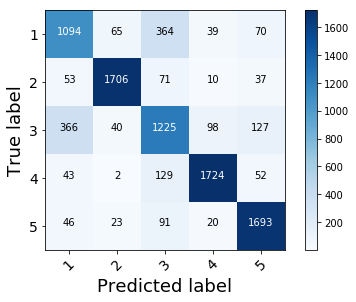

In [253]:
import matplotlib.pyplot as plt
import itertools

% matplotlib inline

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize = 14, fontweight ='medium')
    plt.yticks(tick_marks, classes, fontsize = 14, fontweight ='medium')

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=18, fontweight = 'medium')
    plt.xlabel('Predicted label', fontsize=18, fontweight = 'medium')
    
    
#plt.subplot(131)    
plot_confusion_matrix(confusion_matrix(Y_test, final_pred), classes=target_names)

plt.savefig('hybrid.pdf',bbox_inches='tight')

Confusion matrix, without normalization
[[ 962  129  358   75  108]
 [  42 1713   53   15   54]
 [ 395  136  911  213  201]
 [  27   23   96 1746   58]
 [  48   62   84   51 1628]]


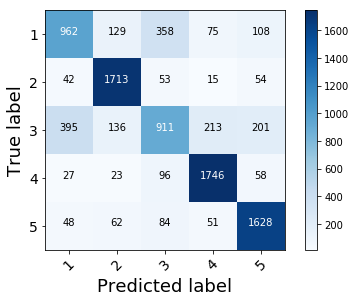

In [126]:
plot_confusion_matrix(confusion_matrix(Y_test, ensembel_test_pred), classes=target_names)

plt.savefig('dnn.pdf')

Confusion matrix, without normalization
[[ 944  130  345  127   86]
 [  35 1748   47   25   22]
 [ 283  112 1062  283  116]
 [  35   14   78 1780   43]
 [  31   40   62   32 1708]]


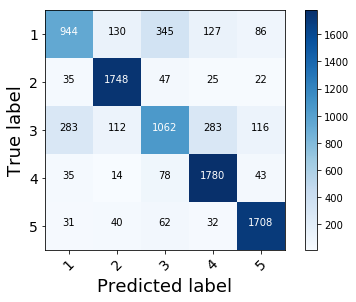

In [127]:
plot_confusion_matrix(confusion_matrix(Y_test, pred_label_test_SVM), classes=target_names)
plt.savefig('svm.pdf')